### 由于之前chapter6_transfer learning 训练好模型以后将文件关闭了，在这里导出训练好的模型并且继续之前的显示
### 需要先创建模型，然后导入网络权重

In [1]:
%matplotlib inline
from tensorflow.python.keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top = False, input_shape=(224,224,3))
vgg16.summary()

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout, Flatten
def build_transfer_model(vgg16):
    # transfer to sequential model and no trainable
    model = Sequential(vgg16.layers)
    print(len(model.layers))
    for layer in model.layers[:15]:
        layer.trainable = False
    #add new output layer
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    
    return model
model = build_transfer_model(vgg16)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [2]:
from tensorflow.python.keras.optimizers import SGD
model.compile(
    loss = 'binary_crossentropy',
    optimizer = SGD(lr=1e-4,momentum = 0.9),
    metrics = ['accuracy']
)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
from tensorflow.python.keras.models import load_model,model_from_json
with open('./models/180913_1408/model.json',mode = 'r') as f:
    model_json = f.read()
model.load_weights('./models/180913_1408/weights/ep_18_ls_0.1.h5')



In [13]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import preprocess_input
## change data scale 
idg_train = ImageDataGenerator(
    rescale = 1/255.,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

In [14]:
# for train data(@ learning)
img_itr_train = idg_train.flow_from_directory(
    'img/shrine_temple/train',
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary'
)
# for confirm data(@ learning)
img_itr_validation = idg_train.flow_from_directory(
    'img/shrine_temple/validation',
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary'
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [15]:
import os
from datetime import datetime
model_dir = os.path.join(
    'models',
    datetime.now().strftime('%y%m%d_%H%M')
)
os.makedirs(model_dir, exist_ok = True)
print('model_dir:',model_dir)
dir_weights = os.path.join(model_dir,'weights')
os.makedirs(dir_weights,exist_ok = True)
print('dir_weights:',dir_weights)

model_dir: models\180914_1021
dir_weights: models\180914_1021\weights


In [16]:
import json
import pickle
# save network
model_json = os.path.join(model_dir, 'model.json')
with open(model_json,'w') as f:    #write only
    json.dump(model.to_json(),f)

# save true label
model_classes = os.path.join(model_dir,'classes.pkl')
with open(model_classes, 'wb') as f:   #write only for binary 
    pickle.dump(img_itr_train.class_indices, f) # save label info
print(img_itr_train.class_indices)

{'temple': 1, 'shrine': 0}


In [17]:
import math
batch_size = 16
steps_per_epoch = math.ceil(img_itr_train.samples/batch_size)
validation_steps = math.ceil(img_itr_validation.samples/batch_size)
print (img_itr_train.samples)

600


In [18]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger
# Callback setting
cp_filepath = os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
    cp_filepath,
    monitor = 'loss',
    verbose = 0,
    save_best_only = False,
    save_weights_only = True,
    mode = 'auto',
    period = 5
)
csv_filepath = os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append = True)

In [19]:
n_epoch = 2
history = model.fit_generator(
    img_itr_train,
    steps_per_epoch = steps_per_epoch,
    epochs = n_epoch,
    validation_data = img_itr_validation,
    validation_steps = validation_steps,
    callbacks = [cp,csv]
)

Epoch 1/2
38/38 [==============================]38/38 [==============================] - 360s 9s/step - loss: 0.1311 - acc: 0.9474 - val_loss: 0.1543 - val_acc: 0.9500

Epoch 2/2
38/38 [==============================]38/38 [==============================] - 350s 9s/step - loss: 0.1131 - acc: 0.9622 - val_loss: 0.1469 - val_acc: 0.9500



In [29]:
from utils import load_random_imgs
test_data_dir = 'img/shrine_temple/test/unknown'
x_test1,true_labels = load_random_imgs(test_data_dir,seed=1)
x_test_preproc1 = preprocess_input(x_test1.copy())/255.
probs = model.predict(x_test_preproc1)
probs

array([[0.01385769],
       [0.6536388 ],
       [0.22065808],
       [0.77546126],
       [0.37233958],
       [0.99921393],
       [0.00684469],
       [0.99999774]], dtype=float32)

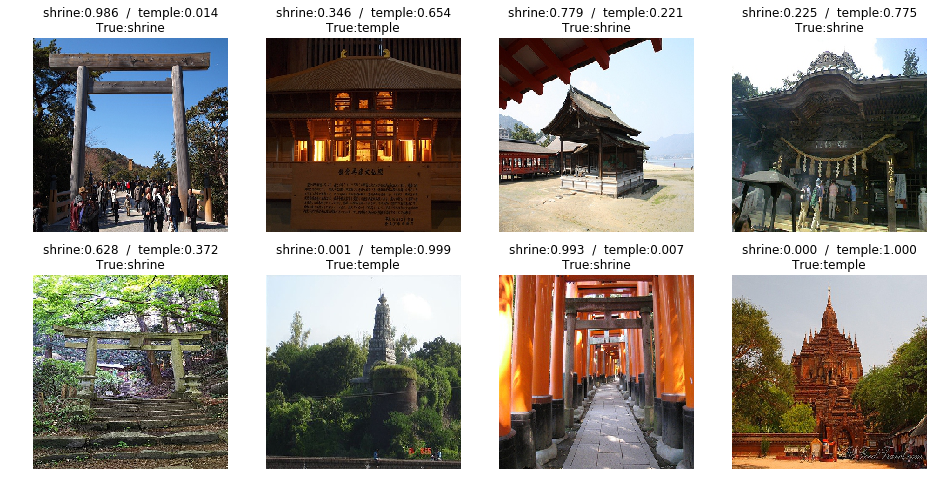

In [30]:
from utils import show_test_samples
show_test_samples(
    x_test1,probs,
    img_itr_train.class_indices,
    true_labels
)